In [1]:
import numpy as np
import codecs


import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties

font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')

from math import sqrt
from random import random

from pandas import DataFrame, ExcelWriter

from collections import Counter

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from scipy.cluster.hierarchy import dendrogram, linkage

HOME = '../'

In [21]:
?font

In [2]:
with open(f'{HOME}data/categories.csv') as infile:
     categories_raw = [x.strip().split('\t')[:-1] for x in infile.readlines()]

categoryNames = categories_raw[0][1:]
words = [x[0] for x in categories_raw[1:]]
    
categories = {name: set() for name in categoryNames}
for line in categories_raw[1:]:
    for i,name in enumerate(categoryNames):
        if(line[i+1]!=''):
            categories[name].add(line[0])

categoryNames = list(categories.keys())
categoryWords = list(categories.values())

categoryVocabulary = set()
for bag in categoryWords:
    categoryVocabulary = categoryVocabulary.union(bag)

numCategories = len(categoryNames)

In [3]:
with codecs.open(f'{HOME}/data/short-names.csv','r','utf-8') as infile:
    raw = infile.readlines()
shortNames = [x.strip().lower() for x in raw]

In [4]:
with open(f'{HOME}/data/lda_summary_final.txt') as infile:
    raw = infile.readlines()
    topicWords = []
    for i,line in enumerate(raw):
        if(i%2==1):
            topicWords.append(set(line.strip().split()))

topicNames = [f'{i}' for i in range(len(topicWords))]
numTopics = len(topicNames)

In [5]:
with codecs.open(f'{HOME}/data/ebu-suud-cleaned.txt','r','utf-8') as infile:
    fatwas = [x.strip() for x in infile.readlines()]
    
numFatwas = len(fatwas)

In [6]:
def score(fatwa,topics):
    tmp0 = fatwa.split()
    N = len(tmp0)
    tmp1 = [ len([w for w in topic if w in tmp0])/N for topic in topics ]
    return tmp1

def myfilter(bags,k, withOther=False):
    def helper1(x):
        if x>=k:
            return(1)
        else:
            return(0)
    def helper2(xs):
        if(sum(xs)>0):
            return xs + [0]
        else:
            return xs + [1]
    
    # with 'other'
    if withOther:
        return np.array([helper2([helper1(x) for x in bag]) for bag in bags])
    else:
        return np.array([[helper1(x) for x in bag] for bag in bags])

fatwa_categories = np.array([score(f,categoryWords) for f in fatwas])
fatwa_topics = np.array([score(f,topicWords) for f in fatwas])

In [7]:
def getWorkSpace(scores,k):
    tmp = [[j for j in range(numFatwas) if scores[j][i]>=k] for i in range(scores.shape[1])]
    return tmp

In [8]:
def Plot3D(coords,sizes,labels,viewPoint,saveName,drop=False,th=55):
    decomposer =  PCA(n_components=3)
    res = decomposer.fit_transform(coords).transpose()
   
    df = DataFrame(res.transpose())
    df.columns = ['x','y','z']
    df.insert(0,'group',labels)
    df.insert(1,'Sizes',sizes)

    if drop:
        df = df.drop([i for i in df.index if sizes[i]<th])
    
    fig = plt.figure(figsize=(30,20))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df['x'], df['y'], df['z'], s=df['Sizes']*25, alpha=.35)
    ax.view_init(viewPoint[0],viewPoint[1])

    for i in df.index:
        ax.text(df.x[i], df.y[i], df.z[i], 
                df.group[i], horizontalalignment='center', 
                size='24', color='black', weight='normal')

    ax.set_xlabel(''); ax.set_ylabel('');ax.set_zlabel('')
    ax.axes.xaxis.set_ticklabels([]); ax.axes.yaxis.set_ticklabels([]); ax.axes.zaxis.set_ticklabels([]);
    plt.savefig(saveName)
    plt.show()

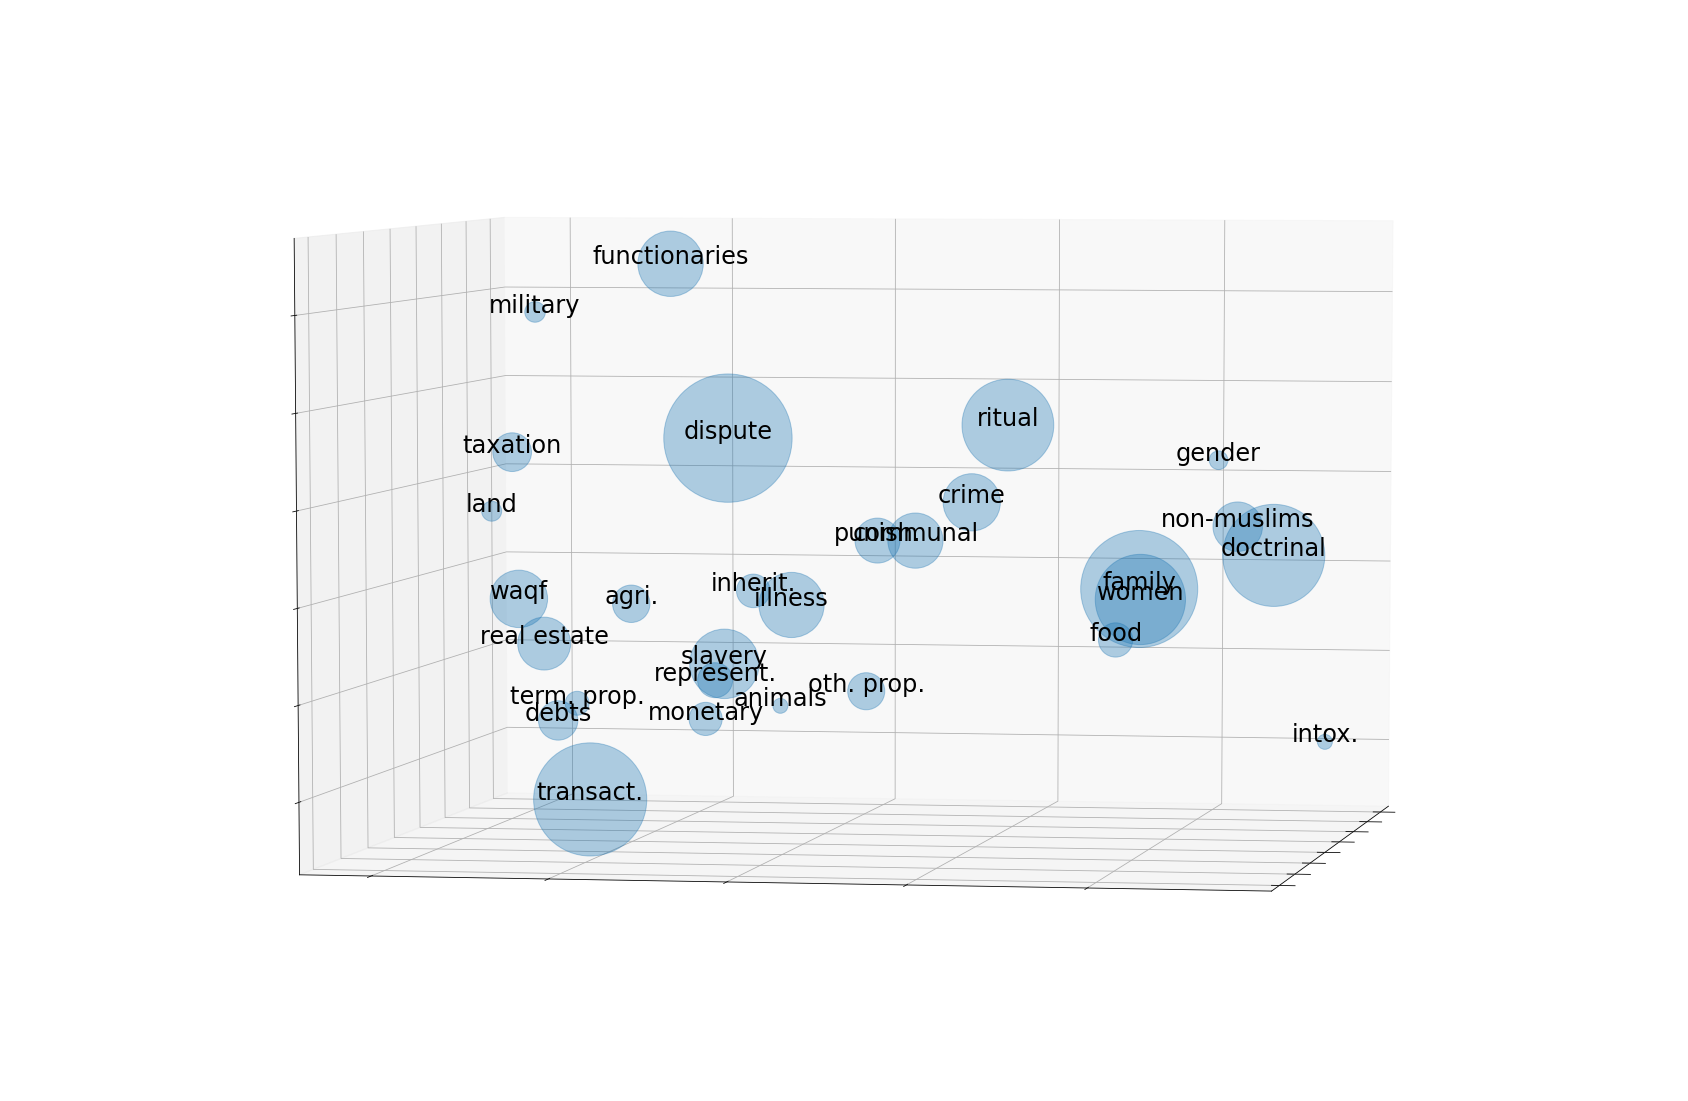

In [9]:
workspace = getWorkSpace(fatwa_categories,0.15)

res = []
for ys in workspace:
    tmp = np.zeros(numCategories)
    for i in ys:
        tmp = tmp + fatwa_categories[i]
    tmp = tmp/len(ys)
    res.append(tmp)
    
coords = np.array(res)
sizes = [len(ys) for ys in workspace]

Plot3D(coords,sizes,shortNames,(5,10),f'{HOME}/images/ebu-suud-categories-projection-3D.png')

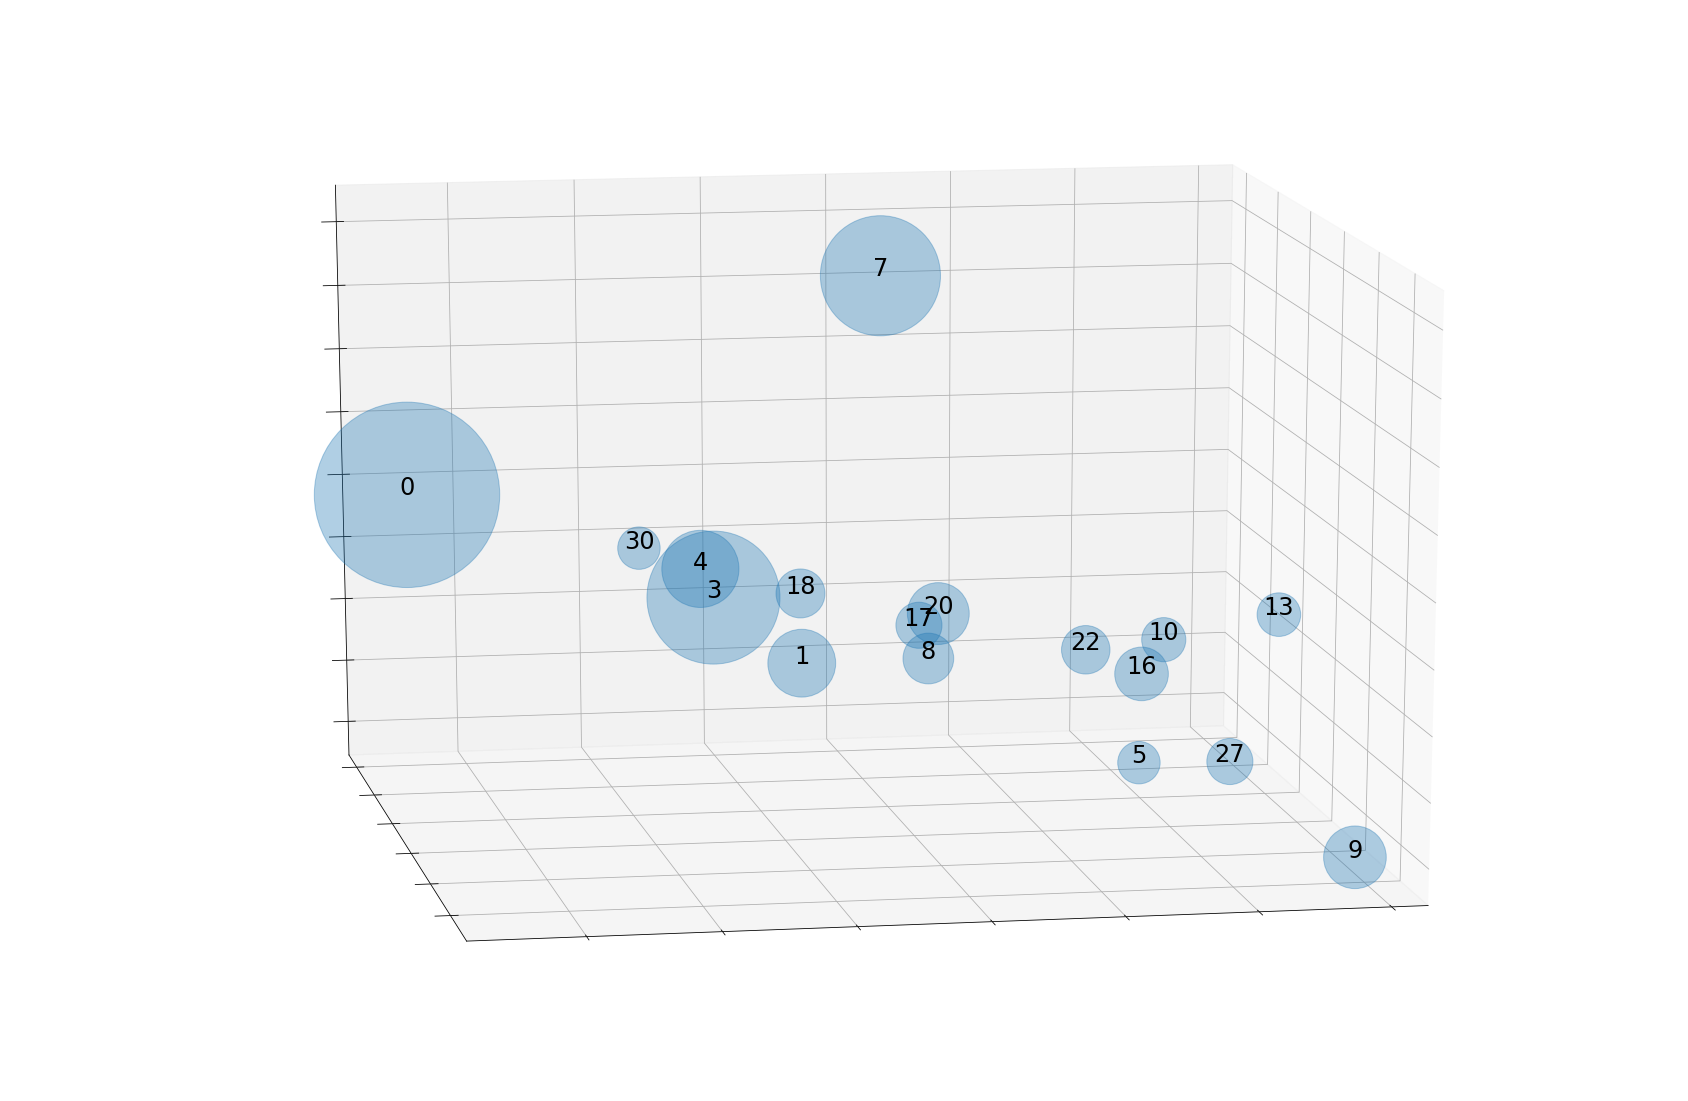

In [10]:
workspace = getWorkSpace(fatwa_topics,0.22)

res = []
for ys in workspace:
    tmp = np.zeros(numTopics)
    for i in ys:
        tmp = tmp + fatwa_topics[i]
    tmp = tmp/len(ys)
    res.append(tmp)
    
coords = np.array(res)
sizes = [len(ys) for ys in workspace]

Plot3D(coords,sizes,topicNames,(15,260),f'{HOME}/images/ebu-suud-topics-projection-3D.png',True,65)

In [13]:
def scoreCount(fatwa,k,categories):
    tmp = fatwa.split()
    N = len(tmp)
    def helper(x):
        if(len(x)>=k):
            return(1)
        else:
            return(0)
    return [helper([x for x in tmp if x in categories[name]]) for name in categoryNames]

def distance(xs,ys,exponent=1):
    return len(set(xs).symmetric_difference(ys))/(len(set(xs).union(ys))**exponent)

def draw_dendogram(dist,labels,method,k=0):
    linked = linkage(dist, method)
    plt.figure(figsize=(8,9))
    dendrogram(linked,
               leaf_font_size=18,
               orientation='right',
               labels = labels,
               distance_sort='descending')
    plt.tight_layout()
    plt.savefig(HOME + '/images/ebu-suud-categories-topic-clustering-with-' + str(k) +'.png')
    plt.show()
  
def experiment(k, method='ward',exponent=1):
    workspace = [[] for i in range(numCategories)]

    for i in range(numFatwas):
        tmp = scoreCount(fatwas[i],k,categories)
        for j in range(numCategories):
            if(tmp[j]>0):
                workspace[j].append(i)
                
    dists = np.zeros((numCategories,numCategories))
    
    for i in range(numCategories-1):
        for j in range(i+1,numCategories):
            dists[i][j] = distance(workspace[i],workspace[j],exponent=exponent)
            dists[j][i] = dists[i][j]
   
    draw_dendogram(dists,shortNames,method=method,k=k)

<ipython-input-13-6ecf90b79934>:15: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(dist, method)


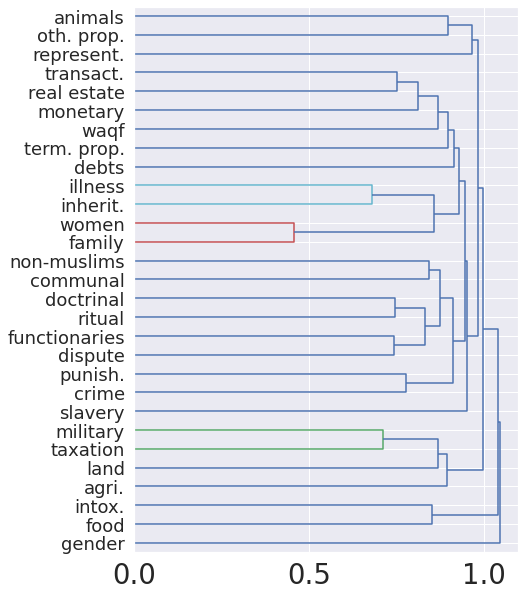

In [28]:
experiment(1,method='average',exponent=1.05)

<ipython-input-13-6ecf90b79934>:15: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(dist, method)


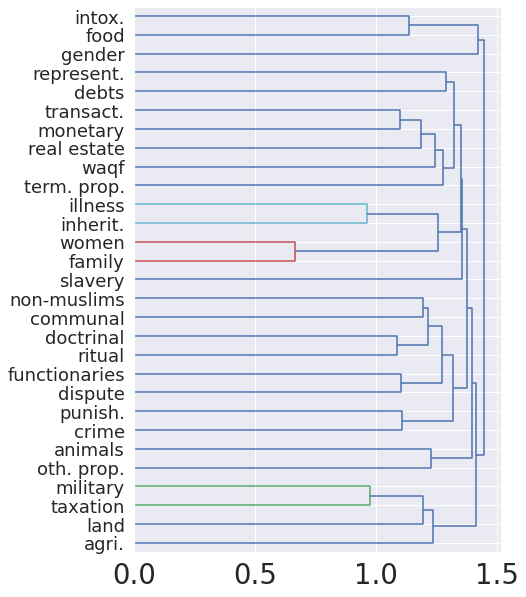

In [29]:
experiment(1,method='average',exponent=1.0)

<ipython-input-13-6ecf90b79934>:15: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(dist, method)


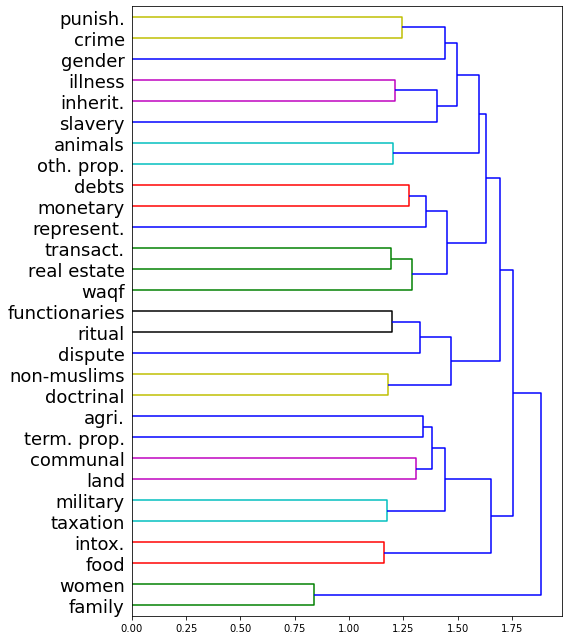

In [15]:
experiment(2)

<ipython-input-13-6ecf90b79934>:15: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(dist, method)


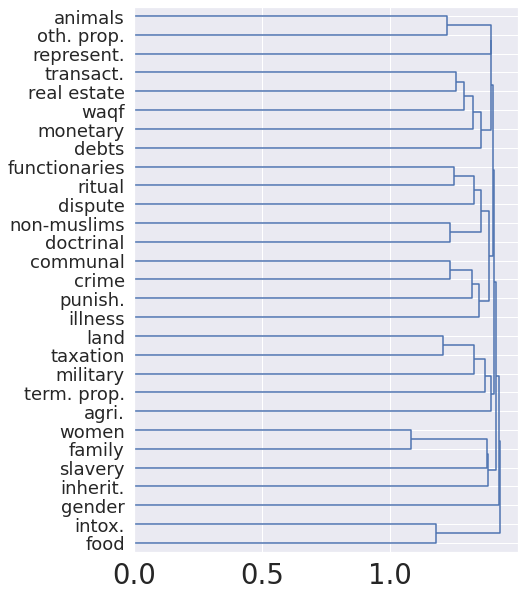

In [37]:
experiment(3,method='average',exponent=1.0)

In [17]:
def supervisedMatrix(k):
    fatwas_scored = np.array([scoreCount(f,k,categories) for f in fatwas])

    tmp = np.matmul(fatwas_scored.transpose(),fatwas_scored)

    res = np.zeros(tmp.shape)
    for i in range(res.shape[0]):
        res[i,:] = tmp[i,:]*100/sum(tmp[i,:])

    
    sns.set(font_scale=2.5)
    plt.figure(figsize=(30,20))
    sns.heatmap(res, 
                cmap=sns.cubehelix_palette(20, start=1, rot=0.0, dark=0.02, light=.99, reverse=False),  
                linewidths=0.0, 
                fmt='2.0f', 
                vmin=0, vmax=60.0,
                annot=True, 
                #cbar_kws={'label': 'Percentage', 'orientation': 'vertical'}, 
                cbar=False,
                xticklabels=shortNames, 
                yticklabels=shortNames)
    plt.tight_layout()
    plt.savefig(f'../images/ebu-suud-supervised-categories-matrix-w{k}.png')
    plt.show()

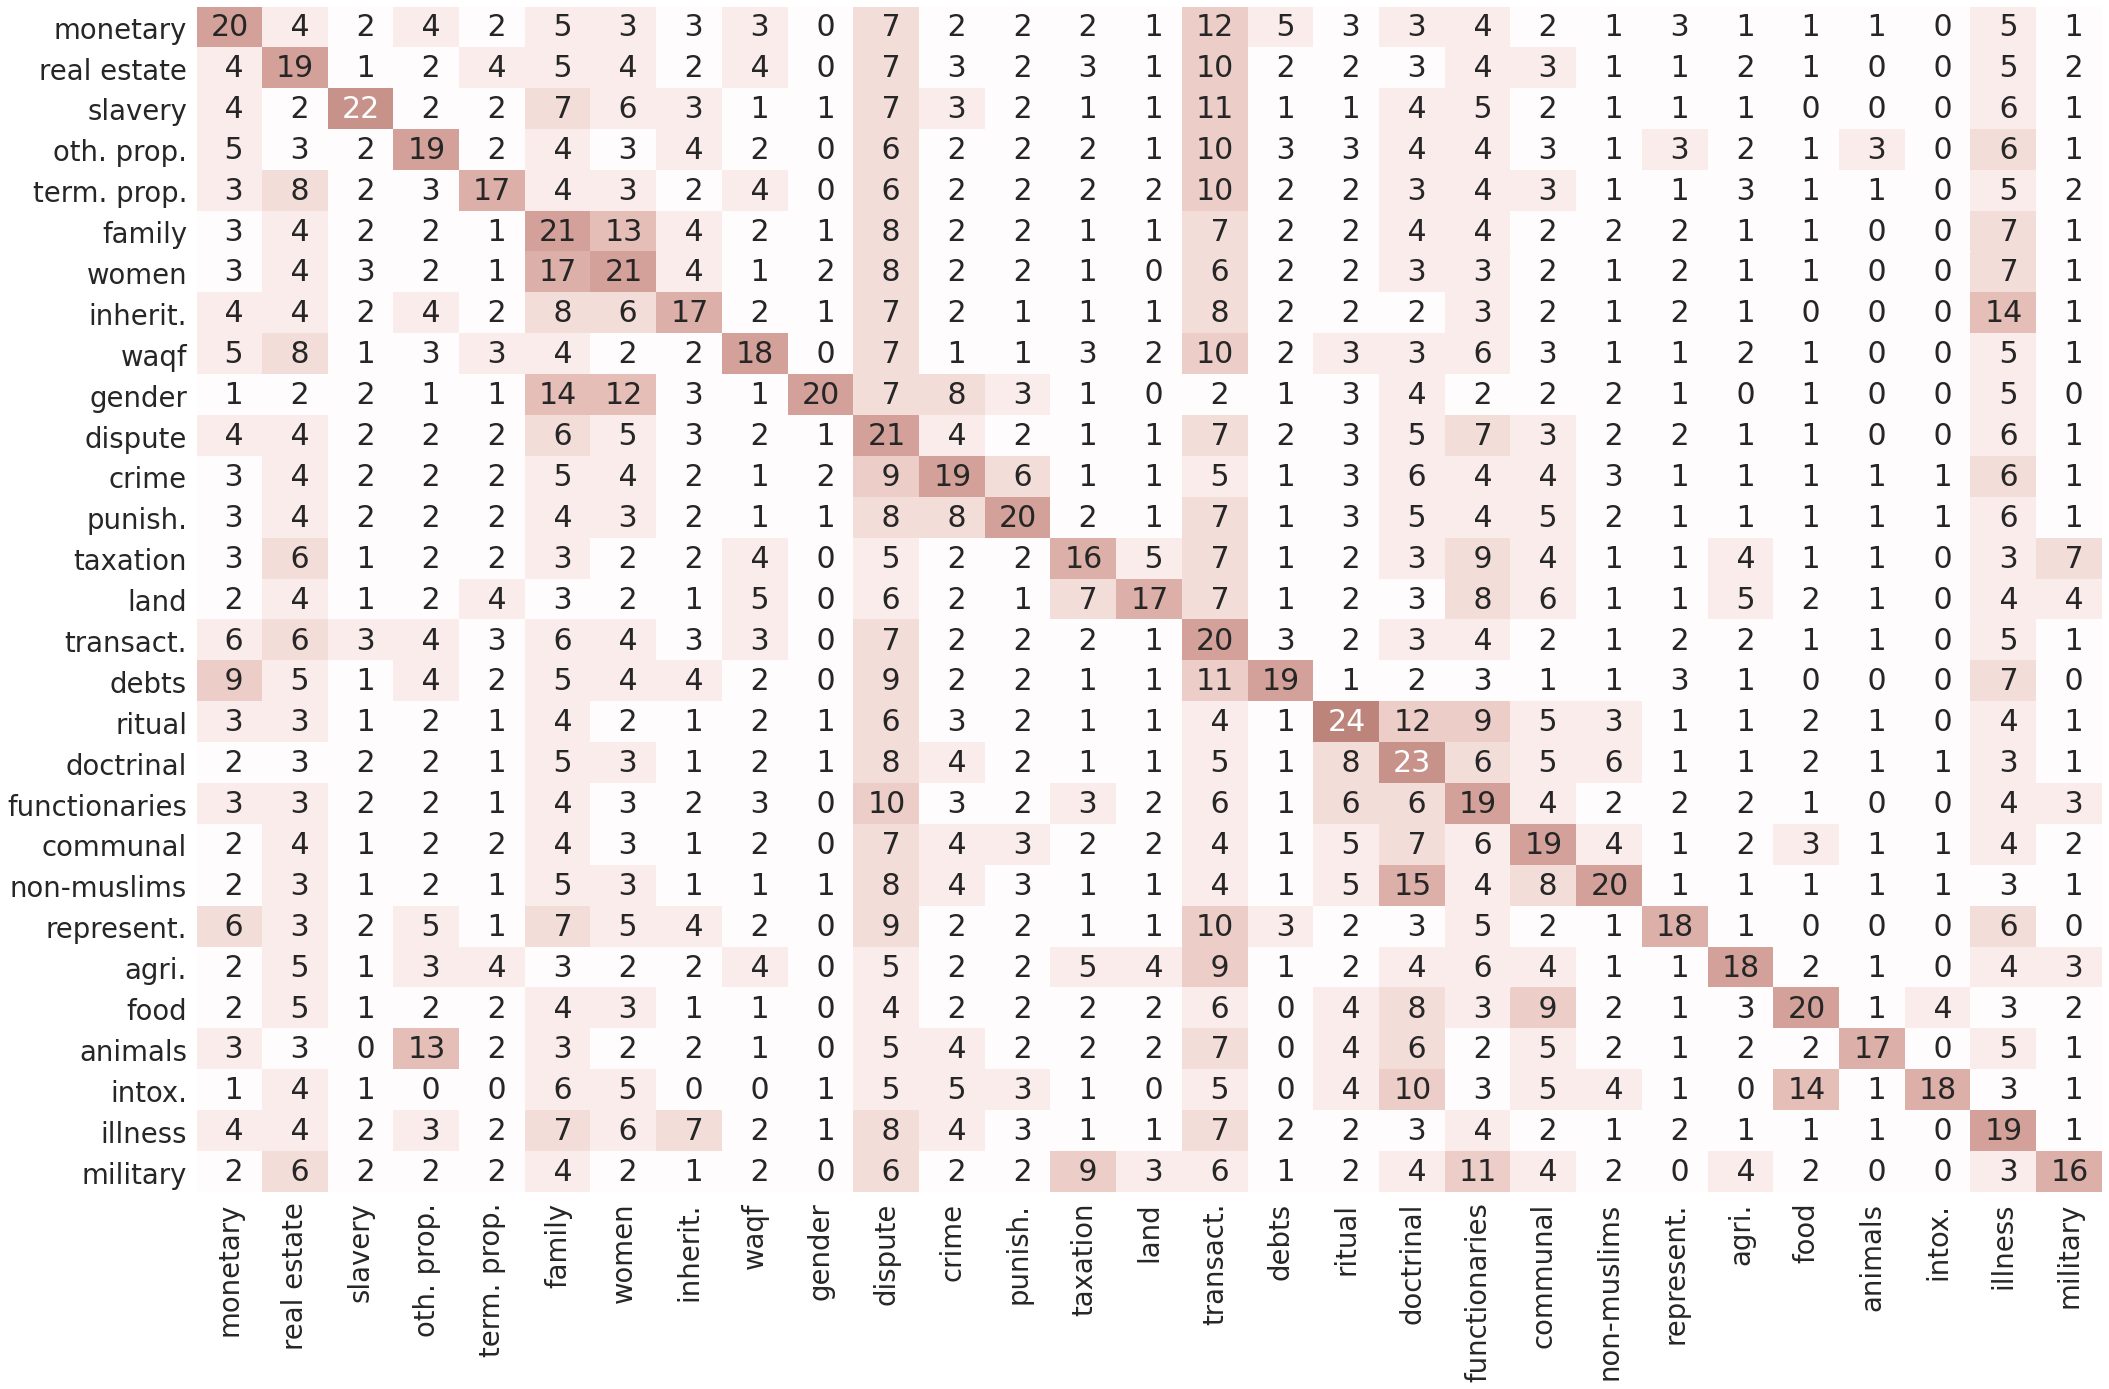

In [18]:
sns.set(style="darkgrid", font='serif', font_scale=1.5)
supervisedMatrix(1)

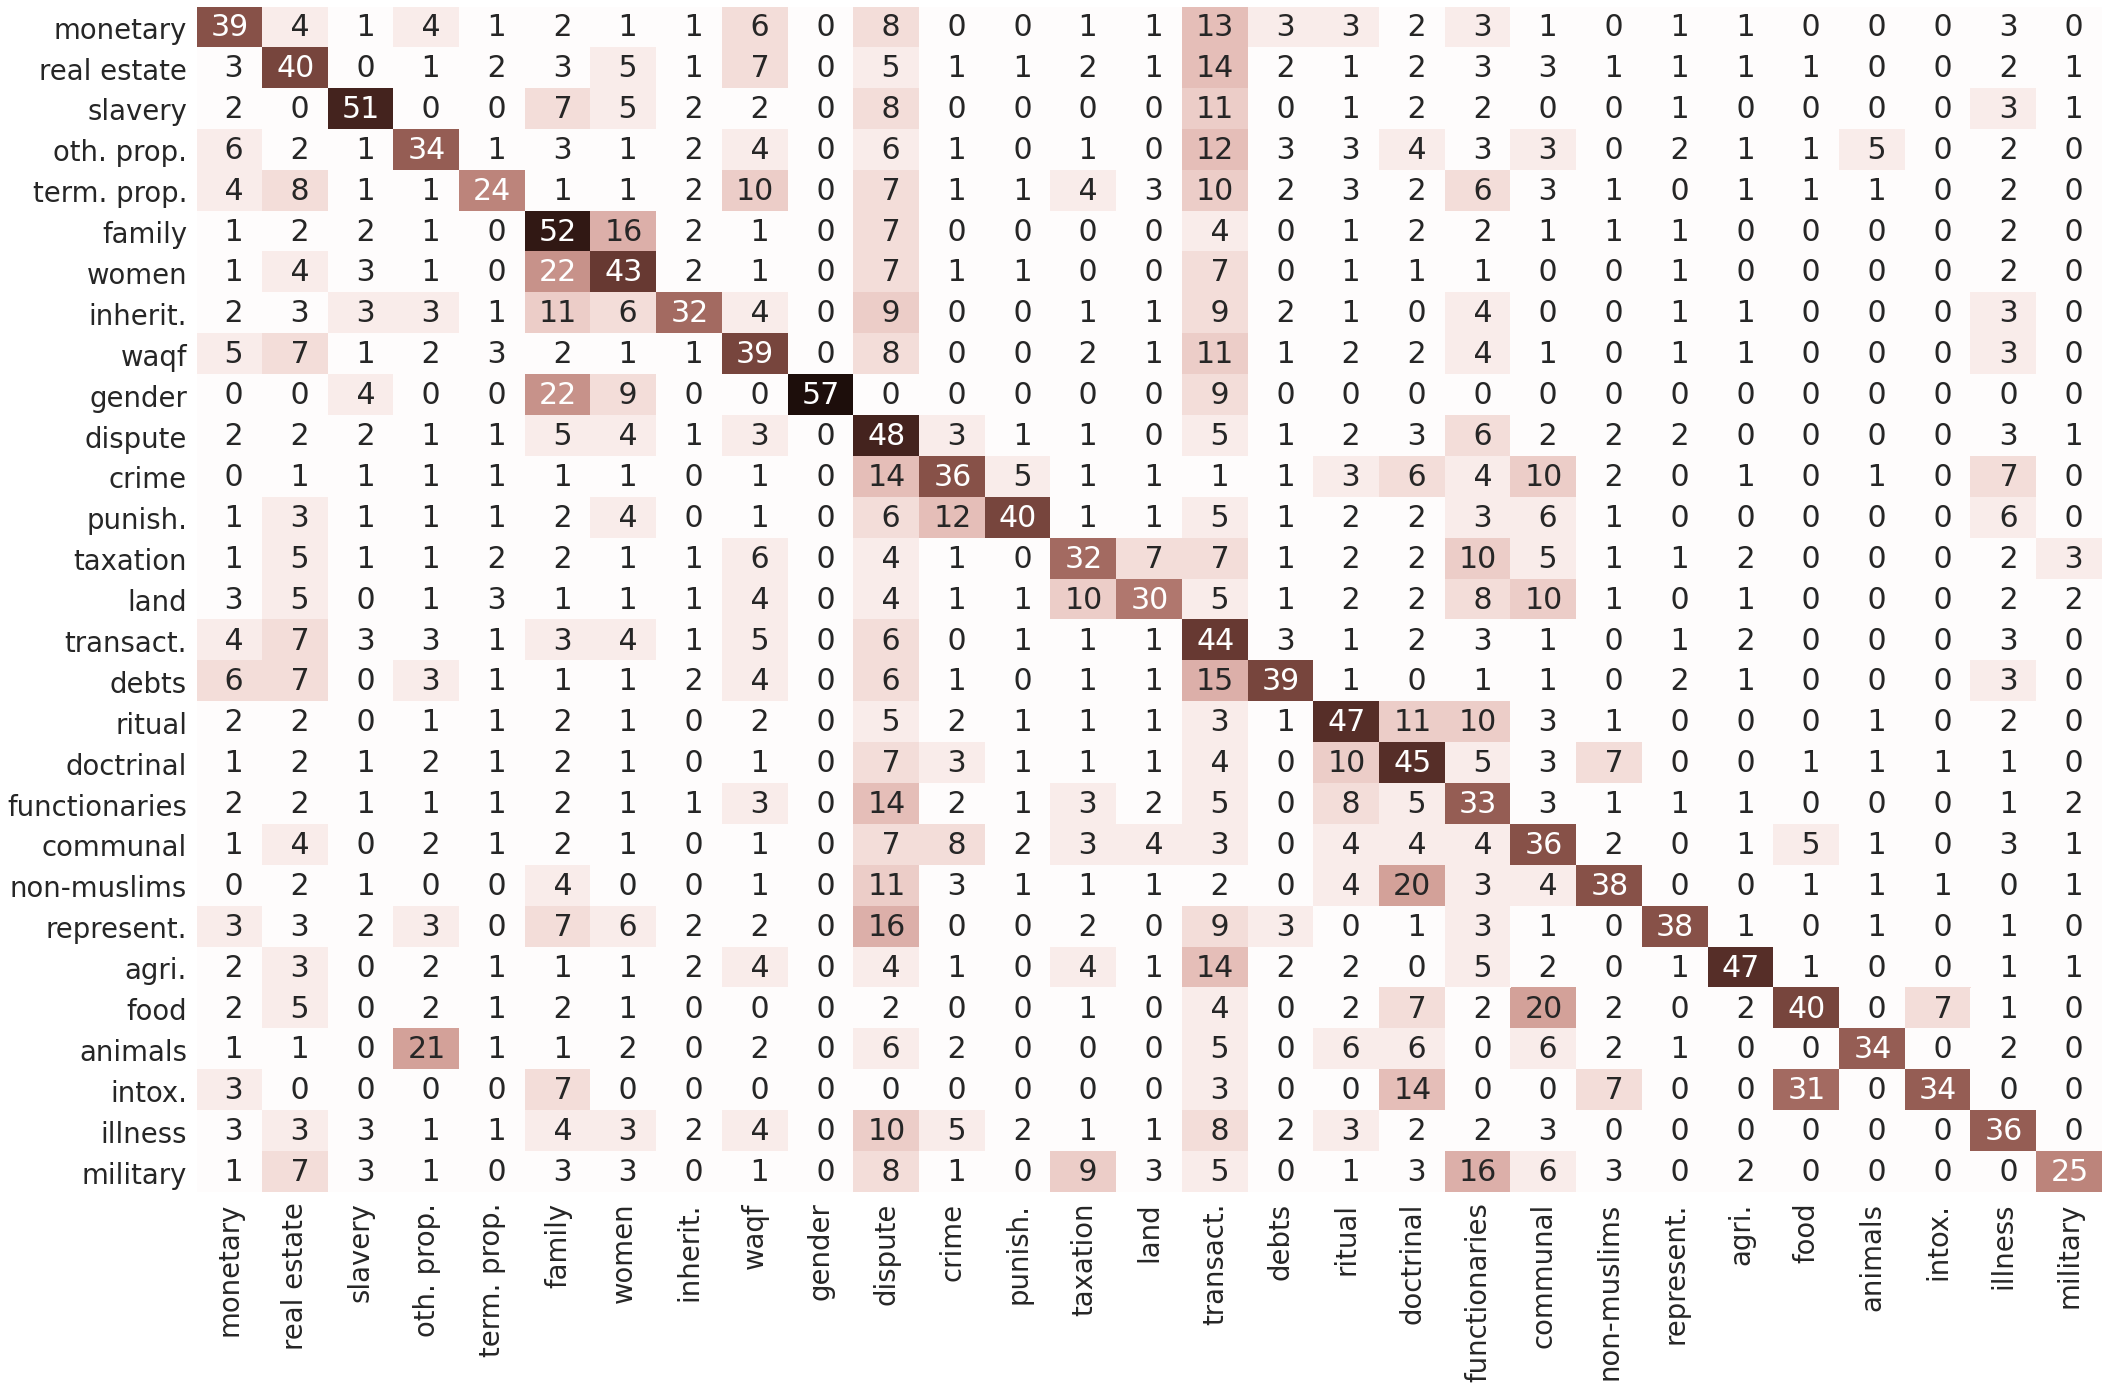

In [19]:
supervisedMatrix(3)

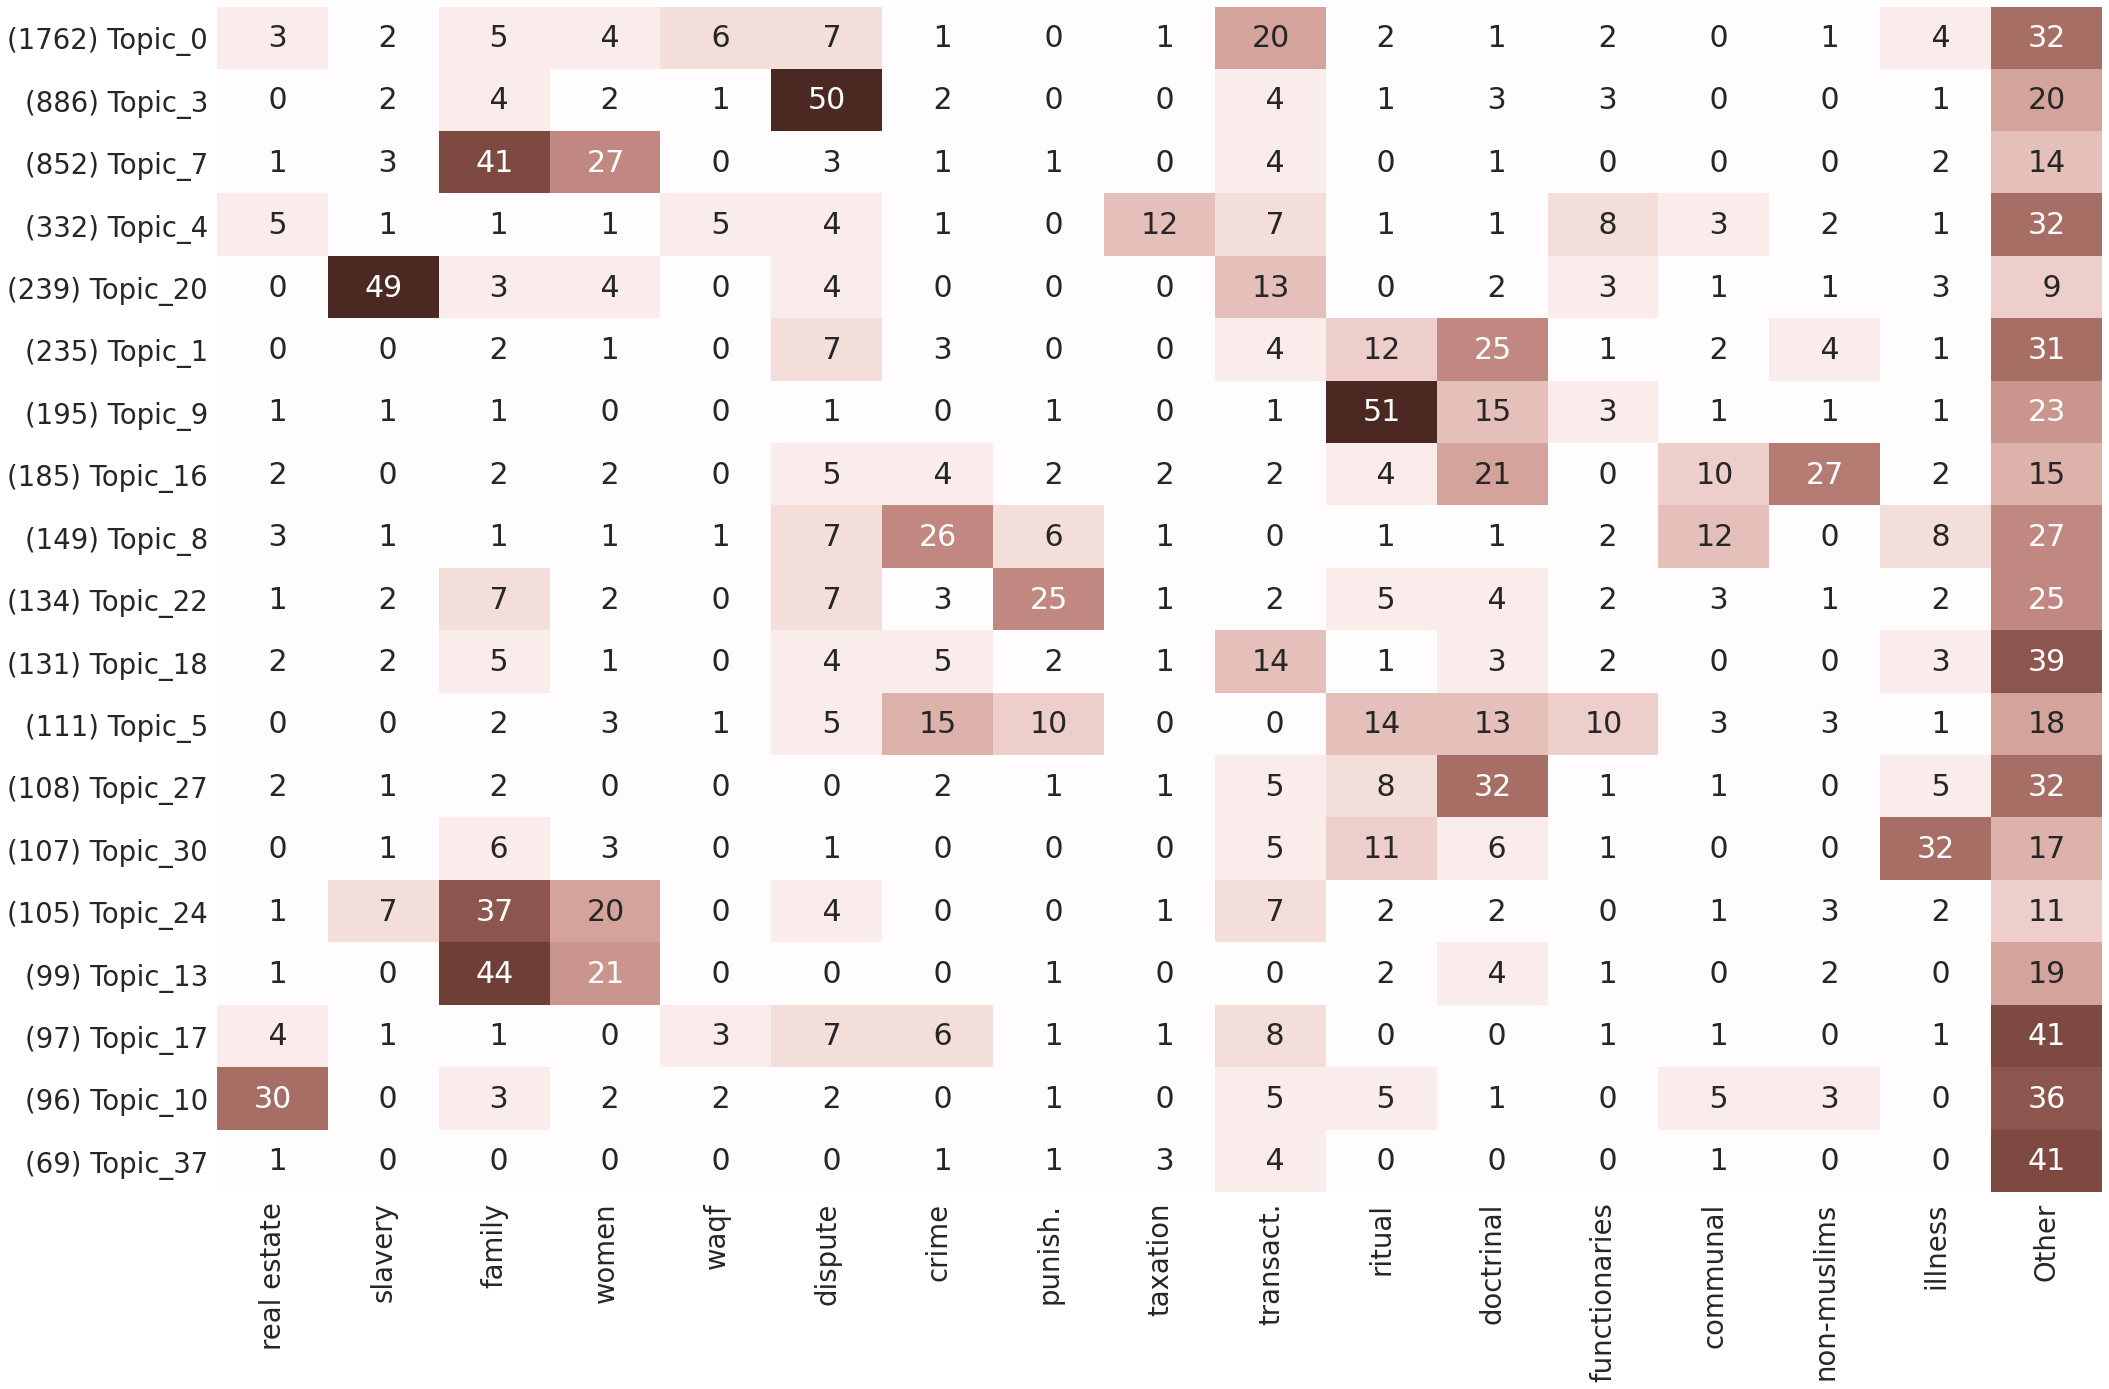

In [20]:
fatwaTopics = [score(f,topicWords) for f in fatwas]
fatwaCategories = [score(f,categoryWords) for f in fatwas]

categoryMatrix = myfilter(fatwaCategories,0.15,withOther=True)
topicMatrix = myfilter(fatwaTopics,0.22)

cross = np.matmul(topicMatrix.transpose(),categoryMatrix)

hcounts = cross.sum(1)
vcounts = cross.sum(0)

hdrop = [topicNames[i] for i in range(cross.shape[0]) if hcounts[i]<65]
vdrop = [shortNames[i] for i in range(cross.shape[1]) if vcounts[i]<85]
#hdrop.append('Other')

res = np.zeros(cross.shape)
for i in range(res.shape[0]):
    res[i,:] = 100*cross[i,:]/sum(cross[i,:])
    
df = DataFrame(res,index=topicNames, columns = shortNames+['Other'])
df.insert(0,"Coverage",cross.sum(1))
df.sort_values(by=['Coverage'], inplace=True, ascending=False)
coverage = df['Coverage']
df = df.drop(index=hdrop,columns=vdrop+['Coverage'])

plt.figure(figsize=(30,20))
sns.set_style("darkgrid", {'font.family': ['serif'], 'font.serif': ['Times','sans-serif']})
sns.set(font_scale=2.5)

sns.heatmap(df, 
            cmap=sns.cubehelix_palette(20, start=1, rot=0.0, dark=0.05, light=.99, reverse=False),  
            #cmap=sns.color_palette("Greys"),  
            linewidths=0.0, 
            fmt='2.0f', 
            vmin=0, vmax=60.0,
            annot=True, 
            #cbar_kws={'label': 'Percentage', 'orientation': 'vertical'}, 
            cbar = False,
            xticklabels=df.columns, 
            yticklabels=[f'({c}) Topic_{x}' for c,x in zip(coverage,df.index)])

plt.tight_layout()
plt.savefig(f'{HOME}/images/ebu-suud-unsupervised-supervised-matrix.png')
plt.show()